<a href="https://colab.research.google.com/github/pranukrish/CMPE258_DeepLearning/blob/main/Assignment6/CustomTensorFunctions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

assert sys.version_info >= (3, 7)

#Import Tensorflow and Keras

In [18]:
from packaging import version
import tensorflow as tf
from tensorflow import keras
import math


assert version.parse(tf.__version__) >= version.parse("2.8.0")

#a) Saving/Loading Models with Custom Objects

In [3]:
# extra code – loads, splits and scales the California housing dataset, then
#              creates a simple Keras model

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [5]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [6]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [7]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.5592 - mae: 0.9135 - val_loss: 0.2739 - val_mae: 0.5823
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2400 - mae: 0.5380 - val_loss: 0.2103 - val_mae: 0.4982


In [8]:
model.save("my_model_with_a_custom_loss") 

In [9]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

#b) Custom loss function

In [10]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

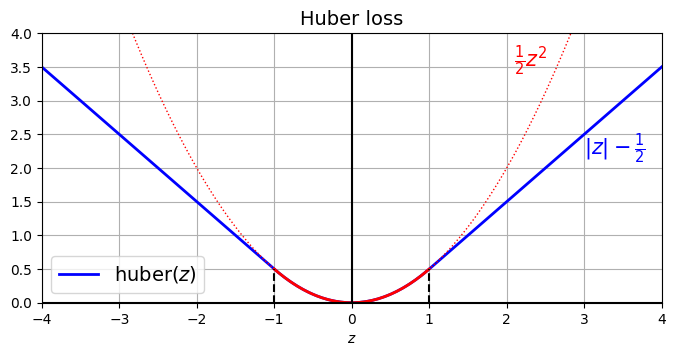

In [12]:
# extra code – shows what the Huber loss looks like
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

#c) Custom regularizer

In [13]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

In [14]:
layer = tf.keras.layers.Dense(1,
                              kernel_regularizer=my_l1_regularizer,
                              )

In [16]:
# extra code – show that building, training, saving, loading, and training again
#              works fine with a model containing many custom parts

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1,
                          kernel_regularizer=my_l1_regularizer
                         )
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.4796 - mae: 1.0891 - val_loss: 3.3968 - val_mae: 0.6354
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6923 - mae: 0.5667 - val_loss: 1.0732 - val_mae: 0.5395


Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5941 - mae: 0.5126 - val_loss: 0.8049 - val_mae: 0.4830
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5105 - mae: 0.4807 - val_loss: 0.5247 - val_mae: 0.4607


#d) Custom activation funtion

#e) Custom initializer

#f) Custom kernel constraint



In [38]:
def leaky_relu(z, alpha=0.01):  
    return np.maximum(alpha*z, z)

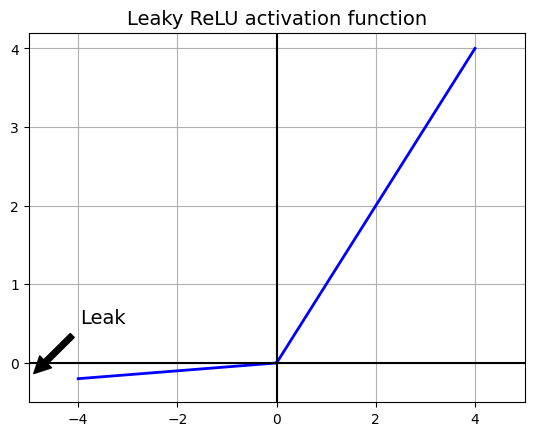

In [40]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [41]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [42]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [43]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [45]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [46]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2965 - accuracy: 0.6065 - val_loss: 0.8809 - val_accuracy: 0.7100
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7895 - accuracy: 0.7373 - val_loss: 0.7082 - val_accuracy: 0.7662
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6785 - accuracy: 0.7741 - val_loss: 0.6421 - val_accuracy: 0.7934
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6210 - accuracy: 0.7924 - val_loss: 0.5902 - val_accuracy: 0.8074
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5839 - accuracy: 0.8049 - val_loss: 0.5598 - val_accuracy: 0.8192
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5572 - accuracy: 0.8126 - val_loss: 0.5375 - val_accuracy: 0.8244
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5368 - accuracy: 0.8190 - val_loss: 0.5186 - val_accuracy:

In [47]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [48]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [49]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [50]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [52]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

#g) Custom Seed using set_seed
#h) Custom Metrics



In [79]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [80]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [81]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [82]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [56]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [57]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [58]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [59]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [60]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [61]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [63]:
model.save("my_model_with_a_custom_metric.h5")

In [67]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [69]:
model.metrics[-1].threshold

2.0

#j) Custom Layer



In [70]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [71]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [72]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
 #   keras.layers.Dense(1),
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 1.2749 - val_loss: 0.4202
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4243 - val_loss: 0.3667
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4090 - val_loss: 0.3606
Epoch 4/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4831 - val_loss: 0.3649
Epoch 5/5
162/162 [==============================] - 0s 941us/step - loss: 0.3722


0.37221211194992065

#k) Custom Model

In [85]:
X_new_scaled = X_test_scaled

In [86]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [87]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [88]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [89]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 4s 3ms/step - loss: 4.7766
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.6405
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 1.3987
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6202
Epoch 5/5
162/162 [==============================] - 0s 1ms/step


In [90]:
model.save("my_custom_model.ckpt")

In [91]:
model = keras.models.load_model("my_custom_model.ckpt")

In [92]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 3s 3ms/step - loss: 0.6612
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6071
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5975
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3802
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5072


In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [95]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 1.2383
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4991
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 0.5118
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4624
Epoch 5/5
162/162 [==============================] - 0s 917us/step


#l) Custom Gradient



In [131]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = backprop'ed from upper layers
        return grads * (1 - 1 / (1 + tf.exp(z)))  # stable grads of softplus

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [132]:
# extra code – shows that the function is now stable, as well as its gradients
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

#m) Custom Training Loop



In [101]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [103]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [104]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [105]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [108]:
from tqdm.notebook import trange
from collections import OrderedDict

with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

#n) Custom TF Functions



In [125]:
def cube(x):
    return x ** 3

In [126]:
cube(2)


8

In [127]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [128]:
tf_cube = tf.function(cube)
tf_cube

In [129]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [130]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

#o) Custom Optimizer



In [114]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [122]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        #self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        #self._set_hyper("decay", self._initial_decay) # 
        #self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config
            #"learning_rate": self._serialize_hyperparameter("learning_rate"),
            #"decay": self._serialize_hyperparameter("decay"),
            #"momentum": self._serialize_hyperparameter("momentum"),
        }

In [119]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
#model.fit(X_train_scaled, y_train, epochs=5)

#p) Custom Dropout

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

In [26]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [27]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 100ms/step


array([[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],
      dtype=float32)

In [28]:
np.round(y_probas[:, :1], 2)

array([[[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],

       [[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0

In [29]:
np.round(y_proba[:1], 2)

array([[0.04, 0.03, 0.09, 0.12, 0.08, 0.01, 0.05, 0.01, 0.23, 0.35]],
      dtype=float32)

In [30]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [31]:
y_pred = np.argmax(y_proba, axis=1)

In [32]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.1433

In [33]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

In [35]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [36]:
mc_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


#q) custom regularizer - Repeated in c which has been implemented



#r) Custom Learning Rate Scheduler

In [23]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [20]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [21]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

430/430 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.3987


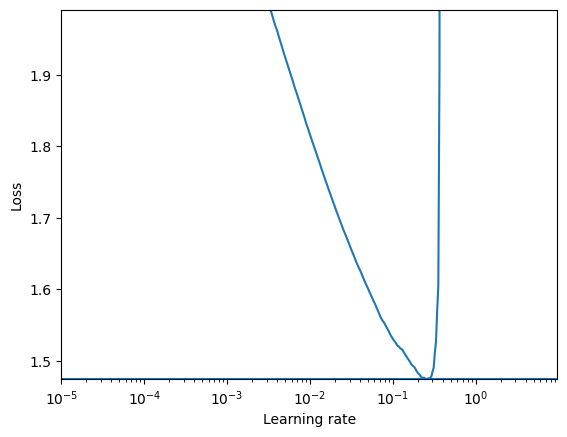

In [24]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)